In [1]:
import requests
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import json
import spacy
import matplotlib.pyplot as plt
from datetime import datetime
import gensim
import gensim.corpora as corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile, datapath
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer     
from sklearn.feature_extraction.text import TfidfVectorizer     
from nltk.corpus import stopwords

unable to import 'smart_open.gcs', disabling that module


In [2]:
# url 
url = "https://www.theguardian.com/uk"
r1 = requests.get(url)
r1.status_code

# save cover page content
coverpage = r1.content


soup1 = BeautifulSoup(coverpage, 'html5lib')

# News identification
coverpage_news = soup1.find_all('h3', class_='fc-item__title')
len(coverpage_news)

120

In [3]:
number_of_articles = len(coverpage_news)
# Empty lists for content, links and titles
news_contents = []
list_links = []
list_titles = []

for n in np.arange(0, number_of_articles):
    if "live" in coverpage_news[n].find('a')['href']:  
        continue
    # Getlink of the article
    link = coverpage_news[n].find('a')['href']
    title = coverpage_news[n].find('a').get_text()
    # Reading the content 
    article = requests.get(link)
    article_content = article.content
    soup_article = BeautifulSoup(article_content, 'html5lib')
    body = soup_article.find_all('div', class_='content__article-body from-content-api js-article__body')
    if (len(body)) == 0:
        continue
    x = body[0].find_all('p')

    list_paragraphs = []
    for p in np.arange(0, len(x)):
        paragraph = x[p].get_text()
        list_paragraphs.append(paragraph)
        final_article = " ".join(list_paragraphs)
    news_contents.append(final_article)
    list_links.append(link)
    list_titles.append(title)

In [4]:
df_features = pd.DataFrame(
     {'Article_Content': news_contents,
      'Article_Title': list_titles, 
      'Article_Link': list_links
    })

# df_show_info
df_show_info = pd.DataFrame(
    {'Article_Title': list_titles,
     'Article_Link': list_links})

In [5]:
df_features.head()

,Article_Content,Article_Title,Article_Link
0,Key workers and NHS staff have raised concerns...,Testing Concerns over delays and errors at UK...,https://www.theguardian.com/society/2020/apr/2...
1,Key workers and NHS staff have raised concerns...,Testing Concerns over delays and errors at UK...,https://www.theguardian.com/society/2020/apr/2...
2,"Lithuania’s capital, Vilnius, has announced pl...",Lithuania Capital to be turned into vast open...,https://www.theguardian.com/world/2020/apr/28/...
3,"Lithuania’s capital, Vilnius, has announced pl...",Lithuania Capital to be turned into vast open...,https://www.theguardian.com/world/2020/apr/28/...
4,"It has dominated global headlines for weeks, a...",Quiz How much do you know about the coronavir...,https://www.theguardian.com/world/2020/apr/28/...


In [6]:
# Helper Functions

def words_to_artical(articles):
    #tokenizes articles
    for article in articles:
        yield(gensim.utils.simple_preprocess(article, deacc=True))  # removes punctuations
        
def remove_of_stopword(texts):
    stop_words = stopwords.words('english')                     ##remove stopword in english
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'say', 'also', 'would', 'may'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def model_bigrams(texts):
    #Applies the bigram model
    return [bigram_mod[doc] for doc in texts]

nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
def data_process(df):
    articles = list(df['Article_Content'])                                          
    list_of_words = list(words_to_artical(articles))                        
    
    common_terms = ["of", "with", "without", "and", "or", "the", "a"]
    bigram = gensim.models.Phrases(list_of_words, 
                                   min_count=4, 
                                   threshold=30, 
                                   common_terms=common_terms)            
    bigram_mod = gensim.models.phrases.Phraser(bigram)                  
    
    return list_of_words, bigram_mod

In [8]:
list_of_words, bigram_mod = data_process(df_features)
list_of_words_lemmatized = lemmatization( list_of_words )
list_of_words_nostops = remove_of_stopword( list_of_words_lemmatized)
data_final = model_bigrams(list_of_words_nostops)


In [9]:
word_dic_con = corpora.Dictionary(data_final)
corpus = [word_dic_con.doc2bow(text) for text in data_final]

In [10]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
   
    #dictionary : Gensim dictionary
    #corpus : Gensim corpus
    #texts : List of input texts
    #limit : Max num of topics #model_list : List of LDA topic models`
    #coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    coherence_values = []
    model_list = []
    #print(word_dic_con)
    #print(corpus)
    #print(data_final)
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=word_dic_con,
                                           num_topics=num_topics,
                                           random_state=100,
                                           passes=20,
                                           per_word_topics=True,
                                           workers=25)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)

    return model_list, coherence_values

start=5; limit=50; step=5
model_list, coherence_values = compute_coherence_values(dictionary=word_dic_con, corpus=corpus, texts=data_final, start=start, limit=limit, step=step)

5
10
15
20
25
30
35
40
45


In [11]:
print(coherence_values)

[0.3226195839907118, 0.3875735703543982, 0.3723561363663951, 0.3989792646196798, 0.32715107523940845, 0.3570580376039896, 0.38735449343432493, 0.4014282193045567, 0.4065755562579575]


In [12]:
final_model_lda = model_list[coherence_values.index(max(coherence_values))]  # Model with highest coherence
temp_file = datapath("final_model_lda")
final_model_lda.save(temp_file)


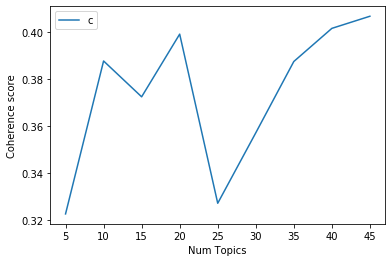

In [17]:
start=5; limit=50; step=5
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()